In [66]:
pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
/usr/share/python-wheels/urllib3-1.25.8-py2.py3-none-any.whl/urllib3/connectionpool.py:999: InsecureRequestWarning: Unverified HTTPS request is being made to host '172.31.102.29'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
/usr/share/python-wheels/urllib3-1.25.8-py2.py3-none-any.whl/urllib3/connectionpool.py:999: InsecureRequestWarning: Unverified HTTPS request is being made to host '172.31.102.29'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  ERROR: Command errored out with exit status 1:
   command: /home/abhishek2828/ml_audio/.venv/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-5l6c734m/tensorflow-gpu/setup.py'"'"'; __file__='"'"'/tmp/pip-install-5l6c734m/tensorflow-gpu/setup.py'"'"';f=getattr(t

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

2023-08-31 12:58:35.822262: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-31 12:58:35.833515: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-31 12:58:35.986765: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-31 12:58:35.988650: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 12:58:36.965121: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
CAPUCHIN_FILE = r"./content/Parsed_Capuchinbird_Clips/XC3776-0.wav"
NOT_CAPUCHIN_FILE = r"./content/Parsed_Not_Capuchinbird_Clips/birds-singing-in-forest-sounds-0.wav"

In [3]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    #load encoded wav file
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    #removes trailing axis
    wav = tf.squeeze(wav, axis=-1)

    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    #goes from 44100Hz to 16000Hz 
    if sample_rate != 16000:
        wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [4]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

2023-08-31 12:58:42.837700: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-31 12:58:42.838190: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-31 12:58:42.941744: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
2023-08-31 12:58:42.942126: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX AVX2 AVX512F FMA


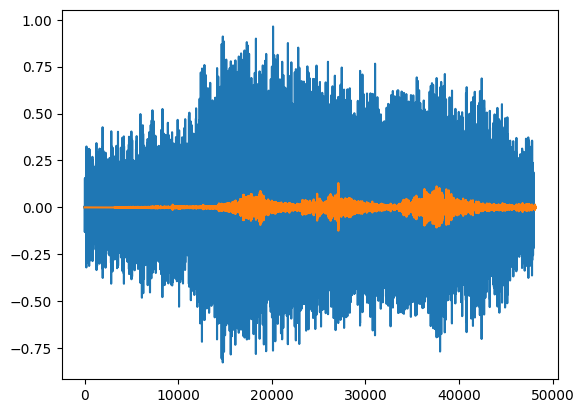

In [5]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [6]:
#DEFINE PATHS TO POSITIVE AND NEGATIVE DATA
POS = os.path.join(r'content', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join(r'content', 'Parsed_Not_Capuchinbird_Clips')
POS

'content/Parsed_Capuchinbird_Clips'

In [7]:
#CREATING TENSORFLOW DATASETS
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')
pos.as_numpy_iterator().next()

b'content/Parsed_Capuchinbird_Clips/XC456236-4.wav'

In [8]:
#ADD LABELS AND COMBINE POSITIVE AND NEGATIVE SAMPLES
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)
data.shuffle(10000).as_numpy_iterator().next()

(b'content/Parsed_Not_Capuchinbird_Clips/sparrow-sound-effect-38.wav', 0.0)

In [10]:
#DETERMINING AVERAGE LENGTH OF A CAPUCHIN CALL

#CALCULATING WAVE CYCLE LENGTH
lengths = []
#os.listdir(os.path.join('content', 'Parsed_Capuchinbird_Clips'))
for file in os.listdir(os.path.join('content', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join(r'content', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [11]:
print(lengths)

[64000, 48000, 56000, 56000, 56000, 48000, 56000, 64000, 64000, 39999, 40000, 56000, 48000, 56000, 48000, 56000, 48000, 48000, 56000, 48000, 48000, 40000, 56000, 64000, 48000, 55999, 40000, 56000, 32000, 40000, 64000, 64000, 48000, 48000, 40000, 48000, 64000, 56000, 40000, 56000, 56000, 48000, 56000, 64000, 56000, 48000, 48000, 56000, 56000, 64000, 56000, 56000, 72000, 48000, 64000, 56000, 48000, 56000, 56000, 64000, 64000, 80000, 48000, 64000, 56000, 48000, 56000, 64000, 32000, 48000, 64000, 64000, 56000, 48000, 56000, 48000, 56000, 56000, 56000, 56000, 48000, 40000, 56000, 56000, 56000, 56000, 56000, 56000, 48000, 40000, 56000, 64000, 56000, 48000, 48000, 56000, 48000, 48000, 56000, 72000, 56000, 64000, 48000, 56000, 64000, 48000, 64000, 64000, 64000, 48000, 48000, 72000, 56000, 40000, 56000, 48000, 48000, 56000, 56000, 56000, 55999, 40000, 48000, 32000, 48000, 40000, 48000, 56000, 48000, 64000, 32000, 48000, 56000, 64000, 56000, 56000, 64000, 56000, 56000, 56000, 40000, 64000, 48000

In [13]:
#CALCULATING MEAN, MIN AND MAX
tf.math.reduce_mean(lengths)


<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [14]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [15]:

tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [16]:
#CONVERTING DATA INTO A SPECTOGRAM

def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype = tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    #basically for the aves less than 48000, it wont fit the 48000 mark,
    #so we add that many no of zeros witht the help of zero_padding so that
    #it reaches the 48000 mark and we can work on the data properly
    spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectogram = tf.abs(spectogram)
    spectogram = tf.expand_dims(spectogram, axis=2)
    return spectogram, label

In [49]:
#TESTING OUT THE FUNCTION AND VIZ THE SPECTOGRAM

filepath, label = positives.shuffle(buffer_size = 10000).as_numpy_iterator().next()
spectogram, label = preprocess(filepath, label)

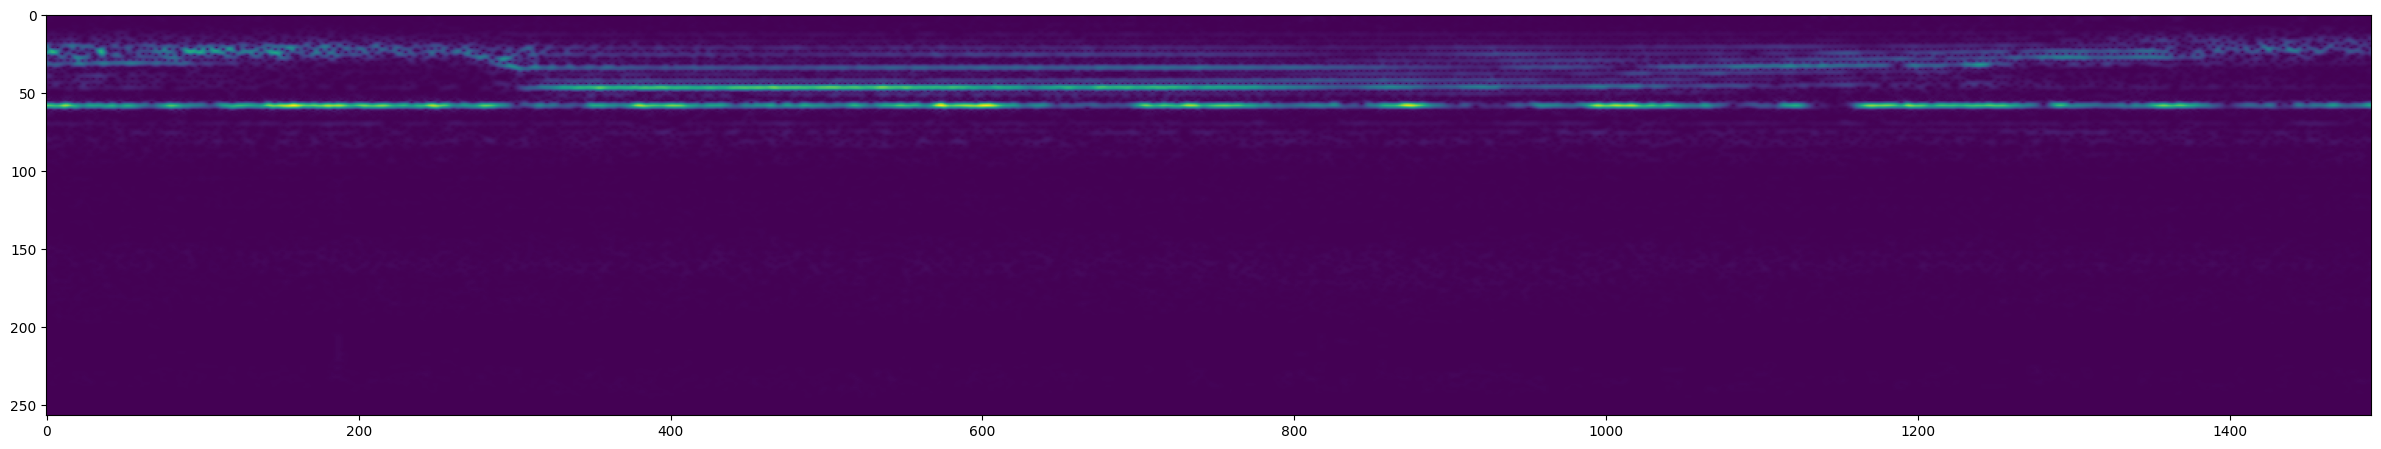

In [50]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

In [51]:
#CREATING TRAINING AND TESTING PARTITIONS
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [69]:
#SPLITTING INTO TRAINING AND TEST PARTITIONS
train = data.take(36)
test = data.skip(36).take(15)

In [70]:
#TEST ONE BATCH
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

In [71]:
labels

array([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [55]:
#BUILDING DEEP LEARNING MODEL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [74]:
model = Sequential([
    Conv2D(8, (3,3), activation='relu', input_shape = (1491, 257,1)),
    Flatten(),
    Dense(units = 64, activation = 'relu'),
    Dense(units = 1, activation = 'sigmoid')
])

model.compile('Adam', loss = 'BinaryCrossentropy', metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

2023-08-31 18:42:21.360058: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (mklcpu) ran out of memory trying to allocate 741.59MiB (rounded to 777615360)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-08-31 18:42:21.360158: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for mklcpu
2023-08-31 18:42:21.360170: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-08-31 18:42:21.360175: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-08-31 18:42:21.360180: I tensorflow/tsl/framework/bfc_allocator.cc:104

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[3037560,64] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:StatelessRandomUniformV2] name: 

In [61]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.